In [1]:
# !wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
# !wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip

In [2]:
# !unzip Flickr8k_Dataset.zip -d images
# !unzip Flickr8k_text.zip -d captions

## Importing the necessary Libraries

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

In [4]:
# Now setup the GPU configuration
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)


cuda:1


In [5]:
l=os.listdir("images/Flicker8k_Dataset")
print(len(l))

8091


In [6]:
# Location of the Flickr8k_Images folder
images_folder = 'images/Flicker8k_Dataset/'

# Location of captions file
captions_filename = 'captions/Flickr8k.token.txt'

# Load the data
file = open(captions_filename, 'r') 

# Read all captions
captions = file.read()

# Close the file
file.close()

# Split the captions by new line character
captions = captions.split('\n')

# Create a dictionary to store the captions of each image
captions_dict = {}

# Iterate through the captions
for caption in captions:
    # Split the caption by white space
    caption = caption.split()
    
    # The first part of the caption is the image id
    
    
    image_id = caption[0]
    
    # The rest of the caption is the caption
    image_caption = caption[1:]
    
    # Remove the filename from the image id
    image_id = image_id.split('.')[0]
    
    # If the image id is not in the dictionary, add it
    if image_id not in captions_dict:
        captions_dict[image_id] = []
    
    # Add the caption to the list
    captions_dict[image_id].append(image_caption)
    
# Display the first 5 captions of the first image
print(captions_dict['1000268201_693b08cb0e'])




[['A', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', '.'], ['A', 'girl', 'going', 'into', 'a', 'wooden', 'building', '.'], ['A', 'little', 'girl', 'climbing', 'into', 'a', 'wooden', 'playhouse', '.'], ['A', 'little', 'girl', 'climbing', 'the', 'stairs', 'to', 'her', 'playhouse', '.'], ['A', 'little', 'girl', 'in', 'a', 'pink', 'dress', 'going', 'into', 'a', 'wooden', 'cabin', '.']]


# Let us plot some images and their captions

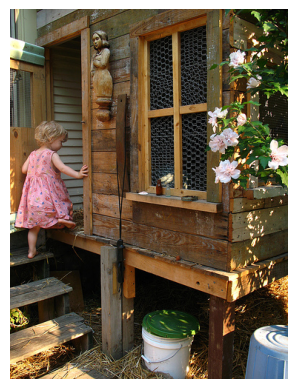

A child in a pink dress is climbing up a set of stairs in an entry way .
A girl going into a wooden building .
A little girl climbing into a wooden playhouse .
A little girl climbing the stairs to her playhouse .
A little girl in a pink dress going into a wooden cabin .


In [7]:
# Now plot some images and their captions
import cv2

# Load the image
image = cv2.imread(images_folder + '1000268201_693b08cb0e.jpg')

# Convert the image to RGB (OpenCV uses BGR by default)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plot the image
plt.imshow(image)
plt.axis('off')
plt.show()

# Print the captions of the image
for caption in captions_dict['1000268201_693b08cb0e']:
    print(' '.join(caption))
    


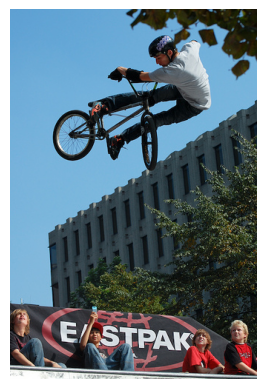

A guy performing a bicycle jump trick for an audience .
A man does a jump trick on a bike .
A man in the air on a BMX bicycle , with 4 people sitting watching him in front of an EASTPAK banner .
A stunt-bicyclist flies above onlookers .
Person on a bicycle jumping high in the air over the sign that reads EASTPAK , others look up at him .





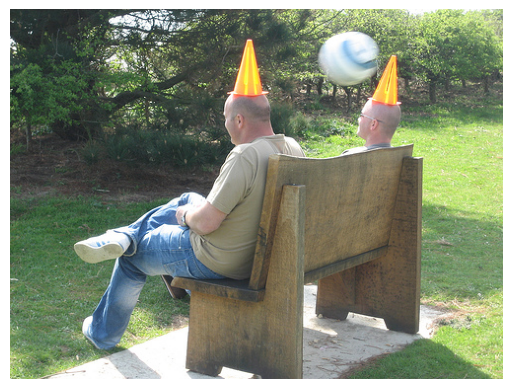

Two bald men on a park bench wearing small yellow traffic cones .
Two dads take a break at the birthday party .
Two men wearing cone hats sit on a wooden bench .
Two men wearing yellow caution cones as hats and one is about to get hit with a ball to the head .
Two men with strange hats sit on a bench .





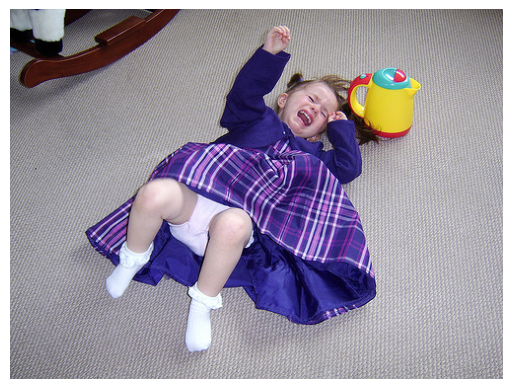

A girl in a purple dress crying on the floor .
A girl in a purple dress is throwing a tantrum .
A little girl in a purple plaid dress is lying on the floor crying .
A little girl in a purple plaid dress lays on the floor and cries with her toy beside her .
A young girl in a purple dress throws a tantrum .





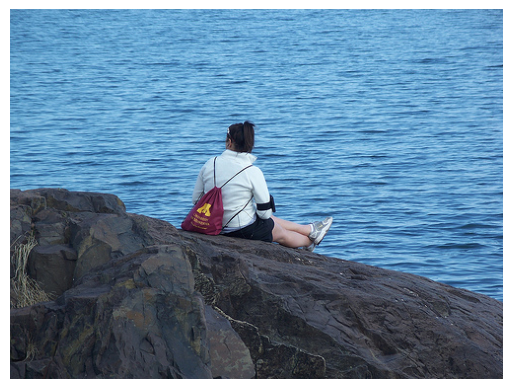

A woman carrying a backpack sits on a rocky ledge overlooking the water .
A woman sits alone on the rocks by a beach .
A woman sits on a rock by the water .
a woman sits on the rock .
A woman wearing a red backpack is sitting on a rock overlooking the water .





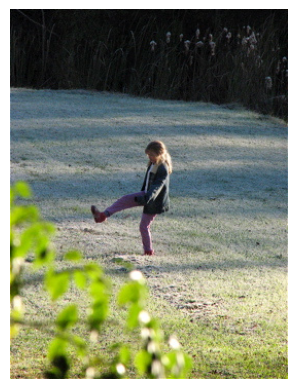

A girl is standing on one leg in the middle of the field .
A girl with her leg out on a lawn .
a little girl kicks into the air .
A warmly dressed girl kicks up her leg outdoors .
Person walking in the field .





In [8]:
# Display five random images and their captions
for i in range(5):
    # Get a random image id
    image_id = np.random.choice(list(captions_dict.keys()))
    
    # Load the image
    image = cv2.imread(images_folder + image_id + '.jpg')
    
    # Convert the image to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Plot the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
    # Print the captions of the image
    for caption in captions_dict[image_id]:
        print(' '.join(caption))
        
    print('\n\n')
    
    

In [9]:
# Now we will create a vocabulary of all the words in the captions
# Create a set to store the words
vocab = set()

# Iterate through the captions
for key in captions_dict.keys():
    for caption in captions_dict[key]:
        # Add all the words to the set
        vocab.update(caption)
        
# Print the total number of words in the vocabulary
print(f"Total words in the vocabulary: {len(vocab)}")

# Now we will create a dictionary to map each word to an index
word_to_index = {}
index_to_word = {}

# Add a special token for unknown words
word_to_index['<unk>'] = 0
index_to_word[0] = '<unk>'

# Add a special token for the start of the sentence
word_to_index['<start>'] = 1
index_to_word[1] = '<start>'

# Add a special token for the end of the sentence
word_to_index['<end>'] = 2
index_to_word[2] = '<end>'

# Add a special token for padding
word_to_index['<pad>'] = 3
index_to_word[3] = '<pad>'

# Start the index from 4
index = 4

# Iterate through all the words in the vocabulary
for word in vocab:
    # Map the word to the index
    word_to_index[word] = index
    
    # Map the index to the word
    index_to_word[index] = word
    
    # Increment the index
    index += 1
    
# Print the size of the vocabulary
print(f"Total vocabulary size after adding special tokens: {len(word_to_index)}")



Total words in the vocabulary: 9630
Total vocabulary size after adding special tokens: 9634


In [10]:
# Now we will create a function to convert the captions to tensors

def convert_caption_to_tensor(caption, word_to_index, max_length):
    
    # Create a list to store the indexes
    tensor = []
    
    # Add the start token
    tensor.append(word_to_index['<start>'])
    
    # Iterate through all the words in the caption
    for word in caption:
        # If the word is in the word_to_index dictionary
        if word in word_to_index:
            # Add the index of the word to the tensor
            tensor.append(word_to_index[word])
        else:
            # Add the index of the unknown token to the tensor
            tensor.append(word_to_index['<unk>'])
            
        if len(tensor) == max_length-1:
            break
    
    # Add the end token
    tensor.append(word_to_index['<end>'])
    
    # Pad the tensor
    while len(tensor) < max_length:
        tensor.append(word_to_index['<pad>'])
    
    # Convert the tensor to a PyTorch tensor
    tensor = torch.tensor(tensor)
    
    return tensor

# Now we will create a function to convert the images to tensors

def convert_image_to_tensor(image_id, images_folder, image_size=(224, 224)):
    
    # Load the image
    
    image_path = images_folder + image_id + '.jpg'
    if not os.path.exists(image_path):
        print(f"Image file not found: {image_path}")
        return None
    
    image = cv2.imread(image_path)
    
    if image is None:
        print(f"Image not found: {image_path}")
        return None
    
    # check if the image is present

    
    # Convert the image to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Resize the image
    image = cv2.resize(image, image_size)
    
    # Convert the image to a PyTorch tensor
    image = torch.tensor(image)
    
    return image
        
       
    
# Now we will create a function to create the dataset

class Flickr8kDataset(torch.utils.data.Dataset):
        
        def __init__(self, images_folder, captions_dict, word_to_index, max_length):
            self.images_folder = images_folder
            self.captions_dict = captions_dict
            self.word_to_index = word_to_index
            self.max_length = max_length
            
            # Get the image ids
            self.image_ids = list(captions_dict.keys())
            
        def __len__(self):
            return len(self.image_ids)
        
        def __getitem__(self, index):
            
            # Get the image id of the image
            image_id = self.image_ids[index]
            
            # Get the image tensor
            image = convert_image_to_tensor(image_id, self.images_folder)
            
            # Get the caption tensor
            caption = convert_caption_to_tensor(self.captions_dict[image_id][0], self.word_to_index, self.max_length)
            
            return image, caption
        
# Now we will create the DataLoader

# Set the maximum length of the caption
max_length = 20

# Create the dataset
dataset = Flickr8kDataset(images_folder, captions_dict, word_to_index, max_length)

# Create the DataLoader
data_loader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True)

# Get a batch of data
images, captions = next(iter(data_loader))

# Print the shape of the images and captions
print(f"shape of images: {images.shape}")

# Print the shape of the captions
print(f"caption shape: {captions.shape}")

# Print the length of data_loader
print(f"Length of data_loader: {len(data_loader)}")



shape of images: torch.Size([256, 224, 224, 3])
caption shape: torch.Size([256, 20])
Length of data_loader: 32


In [11]:
# Now we will create the Encoder using a pre-trained ResNet model

class Encoder(nn.Module):
    
    def __init__(self, embed_size):
        super(Encoder, self).__init__()
        
        # Load the ResNet model
        resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)
        
        # Remove the classification layer
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        
        # Create the linear layer
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        
        # Create the batch normalization layer
        self.batch_norm = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, x):
        
        # Pass the image through the ResNet model
        x = x.float()/255
        x = x.permute(0, 3, 1, 2)
        
        x = self.resnet(x)
        
        # Flatten the output
        x = x.view(x.size(0), -1)
        
        # Pass the output through the linear layer
        x = self.linear(x)
        
        # Pass the output through the batch normalization layer
        x = self.batch_norm(x)
        
        return x
    
# Create the encoder
encoder = Encoder(256)

# Pass the images through the encoder
features = encoder(images)

# Print the shape of the features
print(f"features shape: {features.shape}")



Using cache found in /raid/home/gnaneswaras/.cache/torch/hub/pytorch_vision_v0.6.0


features shape: torch.Size([256, 256])


In [12]:
# Now we will create the Decoder

class Decoder(nn.Module):
        
        def __init__(self, embed_size, hidden_size, vocab_size, max_length, num_layers=1):
            super(Decoder, self).__init__()
            
            self.embed = nn.Embedding(vocab_size, embed_size)
            
            self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
            
            self.linear = nn.Linear(hidden_size, vocab_size)
            
            self.max_length = max_length
            
        def forward(self, features, captions):
            
            # Remove the end token from the captions
            captions = captions[:, :-1]
            
            # Pass the captions through the embedding layer
            embeddings = self.embed(captions)
            
            # Concatenate the features and captions
            embeddings = torch.cat((features.unsqueeze(1), embeddings), dim=1)
            
            # Pass the embeddings through the LSTM
            hiddens, _ = self.lstm(embeddings)
            
            # Pass the hiddens through the linear layer
            outputs = self.linear(hiddens)
            
            return outputs
        
# Create the decoder
decoder = Decoder(256, 512, len(word_to_index), max_length)

# Pass the features and captions through the decoder
outputs = decoder(features, captions)

# Print the shape of the outputs
print(f"outputs shape: {outputs.shape}")




outputs shape: torch.Size([256, 20, 9634])


In [13]:
# Now we will create the model

class ImageCaptioningModel(nn.Module):
    
    def __init__(self, encoder, decoder):
        super(ImageCaptioningModel, self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, images, captions):
        
        # Pass the images through the encoder
        features = self.encoder(images)
        
        # Pass the features and captions through the decoder
        outputs = self.decoder(features, captions)
        
        return outputs
    
# Create the model
model = ImageCaptioningModel(encoder, decoder)

# Pass the images and captions through the model
outputs = model(images, captions)

# Print the shape of the outputs
print(f"outputs shape: {outputs.shape}")




outputs shape: torch.Size([256, 20, 9634])


In [14]:
# Now we will create the loss function and the optimizer

# Create the loss function


model.to(device)
criterion = nn.CrossEntropyLoss()

# Create the optimizer
params = list(model.encoder.linear.parameters()) + list(model.decoder.parameters())

optimizer = optim.Adam(params, lr=0.001)

# Now we will train the model

# Set the number of epochs
num_epochs = 5

# Iterate through the epochs

for epoch in range(num_epochs):
        
        # Set the model to train mode
        model.train()
        
        # Iterate through the data loader
        for images, captions in data_loader:
            
            # Pass the images and captions through the model
            images, captions = images.to(device), captions.to(device)
            
            outputs = model(images, captions)
            
            # Calculate the loss
            loss = criterion(outputs.view(-1, len(word_to_index)), captions.view(-1))
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Backward pass
            loss.backward()
            
            # Update the weights
            optimizer.step()
            
            
            print(f"loss {loss}")
        # Print the loss
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")
        
# Save the model
torch.save(model.state_dict(), 'model.pth')



loss 9.184099197387695
loss 8.707307815551758
loss 8.206798553466797
loss 7.653650760650635
loss 7.240680694580078
loss 6.748077392578125
loss 6.454323768615723
loss 6.080672264099121
loss 5.981963634490967
loss 5.835740566253662
